<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_07_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.07 Variational AutoEncoder

* 날짜:
* 이름:

## 학습내용
    - Variational AutoEncoder를 이해하고 구현한다.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
import sys

## VAE 기본 구현
---

![](https://user-images.githubusercontent.com/24144491/50323466-18d03700-051d-11e9-82ed-afb1b6e2666a.png)

### **| Encoder, Decoder 구현**

In [ ]:
class Sampling(layers.Layer): # ()안에 쓰면 클래스 상속 
    
    def call(self, inputs):
        z_mu, z_sigma = inputs
        z_epsilon = tf.keras.backend.random_normal(shape = tf.shape(z_mu))
        z = (   tf.exp(z_epsilon * 0.5) * z_sigma   ) + z_mu
        return z


class BuildModel():
    def __init__(self, x_shape = (28, 28, 1), z_dims = 100):
        self.x_shape  = x_shape
        self.z_dims = z_dims

    def build_encoder(self, ):
        x = layers.Input(shape = self.x_shape)
        z = layers.Conv2D(32, (3, 3), strides = 2, padding = 'same', activation = 'leaky_relu')(x)
        z = layers.Conv2D(32, (3, 3), strides = 2, padding = 'same', activation = 'leaky_relu')(z)
        self.z_conv_shape = z.shape[1:] # (7, 7, 32)

        z = layers.Flatten()(z)
        z_mu = layers.Dense(z_dims, activation = 'relu')(z)
        z_sigma = layers.Dense(z_dims, activation = 'relu')(z)

        z = Sampling()([z_mu, z_sigma])
        encoder = models.Model(x , [z_mu, z_sigma, z], name = 'Encoder')
        return encoder


    def build_decoder(self, ):
        z = layers.Input(shape = self.z_dims)
        y = layers.Dense(256, activation = 'relu')(z)
        dim = self.z_conv_shape[0] * self.z_conv_shape[1] * self.z_conv_shape[2]
        y = layers.Dense(dim, activation = 'relu')(y)
        y = layers.Reshape(self.z_conv_shape)(y)
        y = layers.Conv2DTranspose(32, 3, strides = 2, padding = 'same', activation = 'leaky_relu')(y)
        y = layers.Conv2DTranspose(1, 3, strides = 2, padding = 'same', activation = 'leaky_relu')(y)
         
        decoder = models.Model(z, y,  name = 'Decoder') 

        return decoder

In [ ]:
x_shape = (28, 28, 1)
z_dims = 10
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()
encoder.summary()
decoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 14, 14, 32)   320         ['input_10[0][0]']               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 7, 7, 32)     9248        ['conv2d_12[0][0]']              
                                                                                                  
 flatten_6 (Flatten)            (None, 1568)         0           ['conv2d_13[0][0]']              
                                                                                            

### **| 손실함수 정의**

![](https://user-images.githubusercontent.com/24144491/50323472-1a016400-051d-11e9-86b7-d8bf6a1a880f.png)

In [ ]:
'''loss.py'''
imgs = (8, 28, 28, 1) # 0 ~ 1

recs = (8, 28, 28, 1) # 0 ~ 1

def get_rec_loss(imgs, recs):
  rec_loss = tf.keras.losses.binary_crossentropy(imgs, recs)
  rec_loss = tf.reduce_mean(rec_loss)
  return rec_loss

def get_kl_loss(z_mu, z_sigma):
  kl_loss = tf.square(z_mu) + ( tf.exp(z_sigma) - z_sigma - 1)
  kl_loss = 0.5*tf.reduce_mean(kl_loss)
  return kl_loss


### **| VAE 구현**

In [ ]:
class VAE():
    def __init__(self, encoder,  decoder, x_shape):
        self.encoder = encoder
        self.decoder = decoder
        self.x_shape = x_shape
    
    def compile(self, optimizer = tf.keras.optimizers.Adam(), ):
        img = layers.Input(shape = x_shape )
        z_mu, z_sigma, z = self.encoder(img)
        rec = self.decoder(z)

        self.vae = models.Model(img, rec, name = 'VAE')
        self.optimizer = optimizer 
    
    @tf.function
    def train_step(self, imgs):
        # imgs.shape = (batch_size, 28, 28, 1)
        with tf.GradientTape() as tape:

            # propagation 
            z_mu, z_sigma, z = self.encoder(imgs)
            recs = self.decoder(z)

            # loss 계산 - (rec loss / kl loss)
            rec_loss = get_rec_loss(imgs, recs) # 원본 이미지와 재구성한 이미지가 최대한 비슷해지면 좋겠다 
            kl_loss = get_kl_loss(z_mu, z_sigma)   # z가 다양하면서, 정보량 유사 
            loss = rec_loss + kl_loss # 각각 다른 weight를 줄 수도 있다. 
            
        # gradient 계산 
        weights = self.vae.trainable_variables
        gradients = tape.gradient(loss, weights)

        # weight 업데이트
        self.optimizer.apply_gradients(zip(gradients, weights))

        return loss, rec_loss, kl_loss  

    def fit(self, x_data, epochs = 1, batch_size=16):

        train_ds = tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size)
        self.batch_size=batch_size
        history = {'loss':[0 for i in range(epochs)], 
                'rec_loss':[0 for i in range(epochs)], 
                'kl_loss':[0 for i in range(epochs)] }

        for epoch in range(1, epochs+1):
            self.epoch=epoch     
            for imgs in train_ds:
                loss, rec_loss, kl_loss = self.train_step(imgs)
                loss, rec_loss, kl_loss = loss.numpy(), rec_loss.numpy(), kl_loss.numpy()
                history['loss'][epoch-1]+=loss
                history['rec_loss'][epoch-1]+=rec_loss
                history['kl_loss'][epoch-1]+=kl_loss
                
            print( f"* [ {epoch} / {epochs}]  loss: {history['loss'][epoch-1]} rec_loss: {history['rec_loss'][epoch-1]} kl_loss: {history['kl_loss'][epoch-1]}" )
            self.plot_sample_imgs(imgs)

    def plot_sample_imgs(self, imgs, n=10):
        plt.figure(figsize=(n,2))
        rec_imgs = self.vae.predict(imgs[:n])
        for i, (img, rec_img) in enumerate(zip(imgs, rec_imgs)):
            plt.subplot(2,n,i+1)
            plt.imshow(np.squeeze(img), cmap='gray_r')
            plt.axis('off')
            plt.subplot(2,n,n+i+1)
            plt.imshow(np.squeeze(rec_img), cmap='gray_r')
            plt.axis('off')
        plt.show()

### **| 학습**

In [ ]:
def get_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float32) / 255
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.astype(np.float32) / 255
    x_test = x_test.reshape(-1, 28, 28, 1)

    return x_train, x_test

In [ ]:
x_train, x_test = get_mnist()
x_train.shape, x_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
x_shape = (28, 28, 1)
z_dims = 100
builder = BuildModel(x_shape, z_dims)
encoder = builder.build_encoder()
decoder = builder.build_decoder()

vae = VAE(encoder, decoder, x_shape)
vae.compile()
vae.vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 100),             323368    
                              (None, 100),                       
                              (None, 100)]                       
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         438369    
                                                                 
Total params: 761,737
Trainable params: 761,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vae.fit(x_train, 5,)

{'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0, 0, 0], 'rec_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0, 0, 0], 'kl_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0, 0, 0]}
{'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0, 0], 'rec_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0, 0], 'kl_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0, 0]}
{'loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0], 'rec_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=float32, numpy=nan>, 0, 0], 'kl_loss': [<tf.Tensor: shape=(), dtype=float32, numpy=nan>, <tf.Tensor: shape=(), dtype=

### **| 결과 확인**

## 새소리 클러스터링
---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! unzip 

In [3]:
! git clone https://github.com/yebiny/Songbird-clusturing.git

Cloning into 'Songbird-clusturing'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 332 (delta 32), reused 65 (delta 18), pack-reused 227
Receiving objects: 100% (332/332), 49.60 MiB | 34.98 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [5]:
sys.path.append('/content/Songbird-clusturing/data_process')
from syllable_generator import *
from draw_tools import * 

In [11]:
gen = SyllableGenerator('/content/drive/MyDrive/Dataset/wav_data_vaeLecture')

In [ ]:
gen.wav_list

/content/drive/MyDrive/Dataset/wav_data_vaeLecture/w58y67_20200428_112731_559.wav


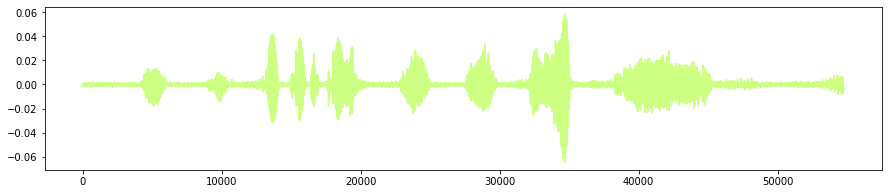

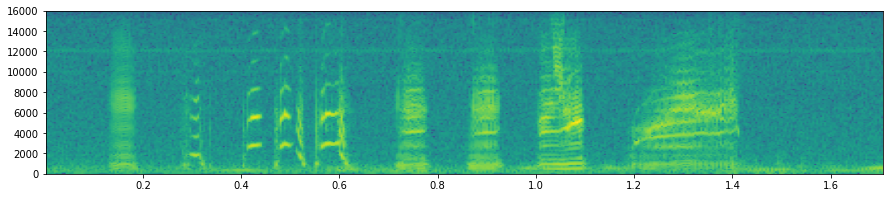

In [13]:
idx = 10
wav = gen.wav_list[idx]
print(wav)

draw_wav(wav)
draw_spectrogram(wav)

In [14]:
syllables = gen.get_syllable_list(gen.wav_list)

* Finish Idx 0 wav file :  w58y67_20200428_100953_641
* Finish Idx 10 wav file :  w58y67_20200428_112731_559
* Finish Idx 20 wav file :  w58y67_20200428_115428_195
* Finish Idx 30 wav file :  w58y67_20200428_115802_306
* Finish Idx 40 wav file :  w58y67_20200428_115916_607
* Finish Idx 50 wav file :  w58y67_20200428_120203_663


In [18]:
print(syllables.shape)
print('idx startPoint length')
print(syllables[:3])

wav_idx = syllables[:, 0]
start_point = syllables[:, 1]
length = syllables[:, 2]

(765, 3)
idx startPoint length
[[    0  3891  2001]
 [    0  8697  1882]
 [    0 13002  1608]]


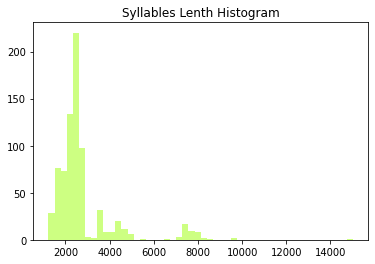

In [20]:
hist_syllable_lenth(length)

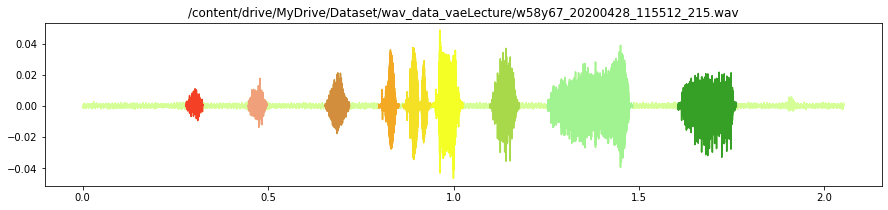

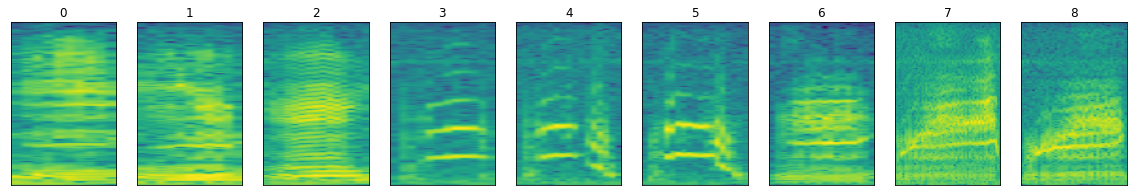

In [24]:
idx = 26
draw_split_wav(gen.wav_list, syllables, idx)
draw_split_spectrogram(gen.wav_list, syllables, idx)

In [26]:
from data_process import *

dp = DataProcess(gen.wav_list, syllables)

ys, imgs = dp.get_dataset()
ys.shape, imgs.shape

* Start process...  total syllables: 765
0
100
200
300
400
500
600
700


((765,), (765, 128, 64))

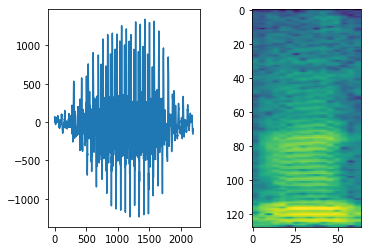

In [27]:
plt.subplot(121); plt.plot(ys[idx])
plt.subplot(122); plt.imshow(imgs[idx])

(765, 128, 64, 1)

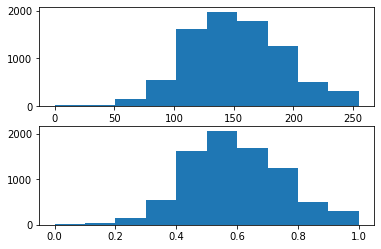

In [33]:
x_data = imgs / 255.
x_data = np.expand_dims(x_data, 3)
plt.subplot(211); plt.hist(imgs[0].flatten())
plt.subplot(212); plt.hist(x_data[0].flatten())
x_data.shape

In [37]:
np.save('/content/drive/MyDrive/Dataset/wav_data_vaeLecture/pre/x_train', x_data)
np.save('/content/drive/MyDrive/Dataset/wav_data_vaeLecture/pre/x_test', x_data)

In [35]:
sys.path.append('/content/Songbird-clusturing/2-Train')
from trainVAE_ver1 import *

In [39]:
z_dims = 2
data_path = '/content/drive/MyDrive/Dataset/wav_data_vaeLecture/' 
save_path = 'result'
vae = TrainVAE(z_dims, data_path, save_path)
vae.vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 64, 1)]      0         
                                                                 
 encoder (Functional)        [(None, 2),               357284    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 128, 64, 1)        357761    
                                                                 
Total params: 715,045
Trainable params: 715,045
Non-trainable params: 0
_________________________________________________________________


In [40]:
vae.train(1000, 4)

* 0 * loss: 5438.159668,  best_loss: 5438.159668, l_rate: 0.001000, lr_count: 0
* 1 * loss: 5342.264160,  best_loss: 5342.264160, l_rate: 0.001000, lr_count: 0
* 2 * loss: 5288.987793,  best_loss: 5288.987793, l_rate: 0.001000, lr_count: 0
* 3 * loss: 5275.534668,  best_loss: 5275.534668, l_rate: 0.001000, lr_count: 0
* 4 * loss: 5272.631836,  best_loss: 5272.631836, l_rate: 0.001000, lr_count: 0
* 5 * loss: 5266.028320,  best_loss: 5266.028320, l_rate: 0.001000, lr_count: 0
* 6 * loss: 5263.404785,  best_loss: 5263.404785, l_rate: 0.001000, lr_count: 0
* 7 * loss: 5260.072754,  best_loss: 5260.072754, l_rate: 0.001000, lr_count: 0
* 8 * loss: 5252.448242,  best_loss: 5252.448242, l_rate: 0.001000, lr_count: 0
* 9 * loss: 5251.429199,  best_loss: 5251.429199, l_rate: 0.001000, lr_count: 0
* 10 * loss: 5246.910156,  best_loss: 5246.910156, l_rate: 0.001000, lr_count: 0
* 11 * loss: 5246.302246,  best_loss: 5246.302246, l_rate: 0.001000, lr_count: 0
* 12 * loss: 5240.725586,  best_loss: 

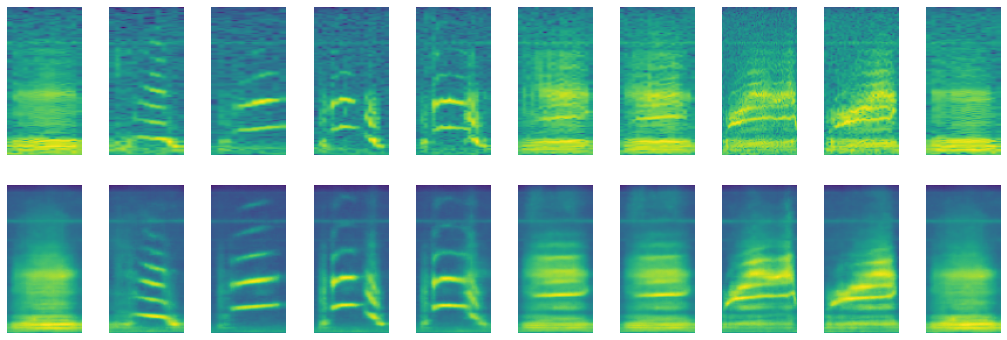

In [43]:
# 복원이 잘되었는지?

recs = vae.vae.predict(x_data)
recs.shape, x_data.shape

plt.figure(figsize = (18, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1); plt.imshow(x_data[i, :, :, 0]); plt.axis('off')
    plt.subplot(2, 10, i + 1 + 10); plt.imshow(recs[i, :, :, 0]); plt.axis('off')

In [52]:
def plot_project(data_2d, c_lenth=1, save=None):

    x = data_2d[:,0]
    y = data_2d[:,1]

    if type(c_lenth)==int:
        fig=plt.figure(figsize=(6,6))
        c = plt.scatter(x, y, marker='.', c='black', alpha=0.4)      
    else:
        fig=plt.figure(figsize=(8,6))
        c = plt.scatter(x, y, c=c_lenth, cmap='jet', marker='.')
        plt.colorbar(c)
    if save!=None:
        plt.savefig(save)
    plt.show()

In [53]:
mu, sigma, z = vae.encoder.predict(x_data)
z.shape

(765, 2)

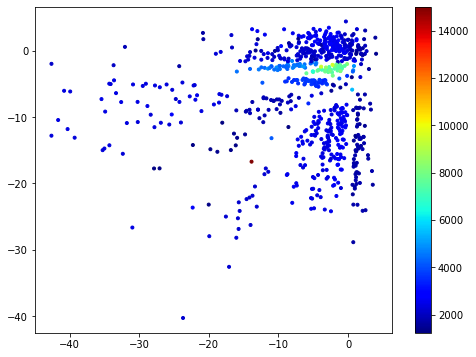

In [54]:
plot_project(z, length)

In [49]:
grid_x = np.linspace(-5, 5, 11)
grid_y = np.linspace(-5, 5, 11)
X, Y = np.meshgrid(grid_x, grid_y)

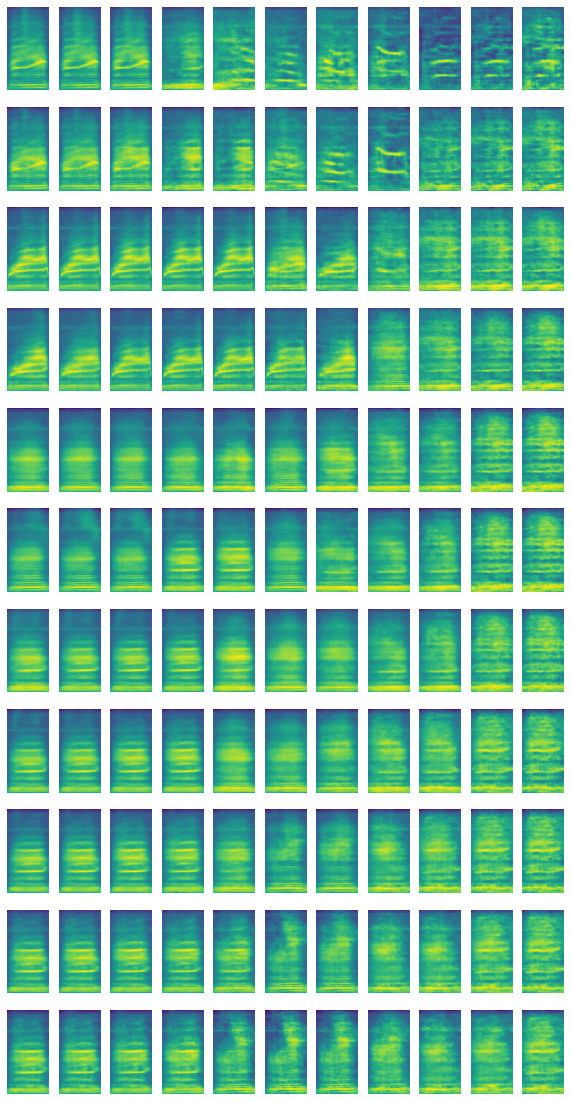

In [51]:
plt.figure(figsize=(10,20))
i=0
for xx, yy in zip(X, Y):
  for x, y in zip(xx, yy):
    z_sample = np.array([[x, y]])
    recs = vae.decoder.predict(z_sample)
    rec = recs[0,:,:,0]
    i+=1
    plt.subplot(11,11,i)
    plt.imshow(rec)
    plt.axis('off')